# Detect Anomalies Using Density Based Clustering

```sklearn.cluster.DBSCAN```

<b>Overview</b>: We will be using DBSCAN to determine if the datapoints fall into a cluster. If they do fall into a cluster, they are likely <u>not</u> anomalies. If they do <u>not</u> fall into a cluster, it is worth investigating further because those points <i>may</i> be anomalies.

In [1]:
#standard DS imports
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pandas as pd
import itertools
import math
from sklearn import metrics
from random import randint

#DBSCAN import
from sklearn.cluster import DBSCAN

#Scaler import
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#ignore warnings import
import warnings
warnings.filterwarnings("ignore")

<hr style="border:2px solid gray">

# Steps to Anomaly Detection using Clustering

1. Select variables you want to cluster: ```df = df[["col1", "col2"]]```
2. Convert to array & dtype float: ```np_array = df.values.astype("float32", copy = False)```
3. Scale to standard normal:
```scaler = StandardScaler().fit(np_array) np_array = scaler.transform(np_array)```

4. Create DBSCAN object and fit: ```dbsc = DBSCAN(eps = .75, min_samples = 15).fit(np_array)```
5. Extract labels: ```labels = dbsc.labels_```
6. Add labels back to original dataframe:
```df['labels'] = labels```

7. Explore:
```df.labels.value_counts() sns.scatterplot(df.col1, df.col2, hue=df.labels)```

<i> For this example, we will not be following Steps 2 & 6.
<br>
    
Step 2:
- by using fit_transform we already return an array
- our datatypes are already correct

Step 6:
- Our dataframe already returns with the label on it

<hr style="border:2px solid gray">

# Acquire

In [2]:
from env import host, user, password

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

In [3]:
url = get_db_url("grocery_db")

sql = """
select *
from grocery_customers
"""

df = pd.read_sql(sql, url, index_col="customer_id")
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 30.9 KB


<hr style="border:1px solid black">

# Follow the Steps

# Step 1:

In [5]:
# Cluster on all or a selected subset of features
grocery_milk_fresh = df[["Grocery", "Milk", "Fresh"]]
grocery_milk_fresh.head(2)s

,Grocery,Milk,Fresh
customer_id,,,
0,7561,9656,12669
1,9568,9810,7057


# Step 2:

In [6]:
#convert to an array and turn into float
#np_array = df.values.astype("float32", copy = False)

# Step 3:

In [7]:
# Make the scaler
mms = MinMaxScaler()

#Fit/transform the scaler
grocery_milk_fresh = mms.fit_transform(grocery_milk_fresh)

#
grocery_milk_fresh

array([[0.08146416, 0.13072723, 0.11294004],
       [0.10309667, 0.13282409, 0.06289903],
       [0.08278992, 0.11918086, 0.05662161],
       ...,
       [0.32594285, 0.21013575, 0.1295431 ],
       [0.02402535, 0.02622442, 0.091727  ],
       [0.02702178, 0.02237109, 0.02482434]])

<hr style="border:2px solid gray">

### Side Step

In [8]:
# Now, let's add the scaled value columns back onto the dataframe
columns = ["Grocery", "Milk", "Fresh"]
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(grocery_milk_fresh, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])

In [9]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Grocery,Scaled_Milk,Scaled_Fresh
0,2,3,12669,9656,7561,214,2674,1338,0.081464,0.130727,0.112940
1,2,3,7057,9810,9568,1762,3293,1776,0.103097,0.132824,0.062899
2,2,3,6353,8808,7684,2405,3516,7844,0.082790,0.119181,0.056622
3,1,3,13265,1196,4221,6404,507,1788,0.045464,0.015536,0.118254
4,2,3,22615,5410,7198,3915,1777,5185,0.077552,0.072914,0.201626


<hr style="border:2px solid gray">

# Step 4:

<b>DBSCAN</b>: Density-Based Spatial Clustering of Applications with Noise

- Clusters together objects based on the density of the space around them.

- Those with many neighbors will be clustered together, while objects sitting in a low density space will not be placed in a cluster.

```sklearn.cluster.DBSCAN```

<b>Pros</b>:
- Doesn't require pre-set number of clusters.

- Identifies outliers as noise.

- Able to find arbitrarily sized and arbitrarily shaped clusters

- Requires only 2 parameters (distance and samples)

- Is not largely affected by the order of the data


<b>Construct a DBSCAN object that requires a minimum of 20 data points in a neighborhood of radius 0.1 to be considered a core point.</b>

In [10]:
# Make the object
dbsc = DBSCAN(eps = .10, min_samples = 20)

# Fit the object
dbsc.fit(grocery_milk_fresh)

DBSCAN(eps=0.1, min_samples=20)

# Step 5: Create label/cluster

<div class="alert alert-block alert-info">
<b>Note:</b> DBSCAN makes a cluster called "-1" that contains the noise/outliers
</div>

In [11]:
# Assign the cluster labels
df['gmf_labels'] = dbsc.labels_

In [12]:
#see what this dataframe looks like
df.sample(5)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Grocery,Scaled_Milk,Scaled_Fresh,gmf_labels
386,1,3,1206,3620,2857,1945,353,967,0.030762,0.048541,0.010727,0
32,1,3,21632,1318,2886,266,918,405,0.031075,0.017197,0.192861,0
136,1,3,4625,8579,7030,4575,2447,1542,0.075741,0.116063,0.041213,0
360,1,3,19746,2872,2006,2601,468,503,0.021589,0.038356,0.176044,0
116,1,3,11173,2521,3355,1517,310,222,0.036130,0.033577,0.099601,0


# Step 6: 

In [13]:
#df['labels'] = labels

# Step 7: Explore

<div class="alert alert-block alert-info">
<b>Remember:</b> 
<br>
    
- <b>-1</b>: refers to data that does <u>not</u> fall into a cluster
- <b>0</b>: refers to data that does fall into a cluster
</div>

In [14]:
#let's see what labels holds
df.gmf_labels.value_counts()

 0    409
-1     31
Name: gmf_labels, dtype: int64

In [15]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Grocery,Scaled_Milk,Scaled_Fresh,gmf_labels
0,2,3,12669,9656,7561,214,2674,1338,0.081464,0.130727,0.112940,0
1,2,3,7057,9810,9568,1762,3293,1776,0.103097,0.132824,0.062899,0
2,2,3,6353,8808,7684,2405,3516,7844,0.082790,0.119181,0.056622,0
3,1,3,13265,1196,4221,6404,507,1788,0.045464,0.015536,0.118254,0
4,2,3,22615,5410,7198,3915,1777,5185,0.077552,0.072914,0.201626,0


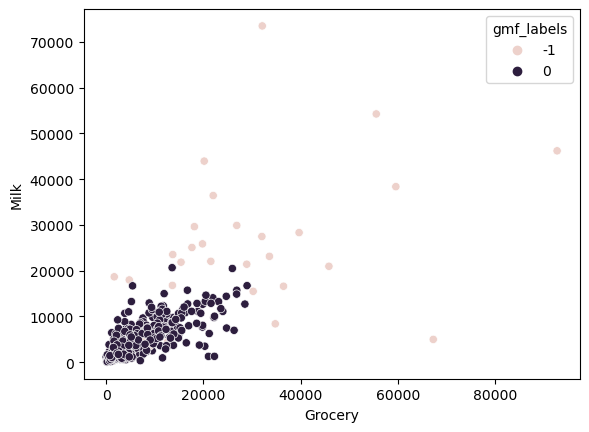

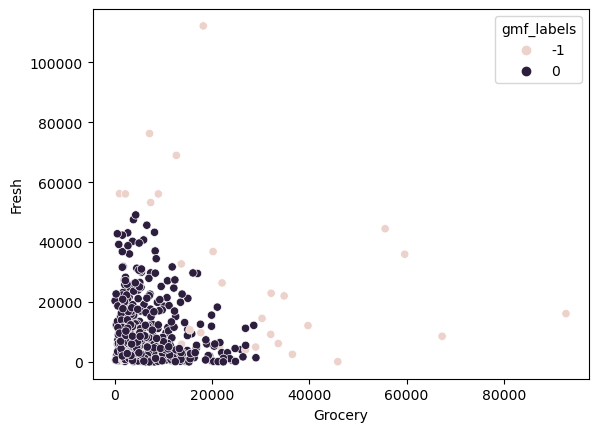

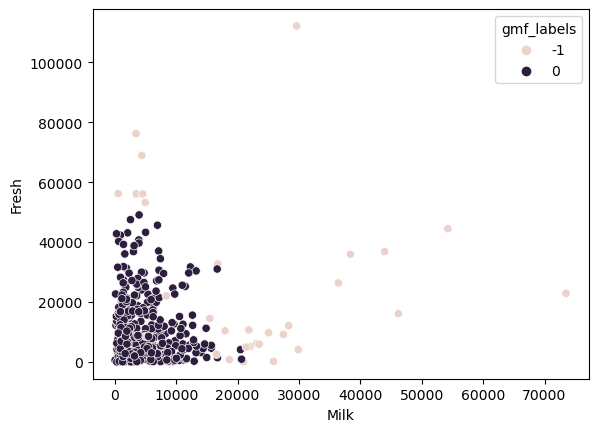

In [16]:
sns.scatterplot(x=df.Grocery, y=df.Milk, hue=df.gmf_labels)
plt.show()

sns.scatterplot(x=df.Grocery, y=df.Fresh, hue=df.gmf_labels)
plt.show()

sns.scatterplot(x=df.Milk, y=df.Fresh, hue=df.gmf_labels)
plt.show()

<div class="alert alert-block alert-info">
<b>Note:</b> If I were going to do a deep dive into this, I might want to use itertools to get all the combinations. Then I would create a DBSCAN for each combination and visualize them using the different features (hue = xx_labels).
</div>

In [20]:
#create a df of ONLY anomalies
anomalies = df.loc[df['gmf_labels'] == -1]

In [18]:
#let's see how many entries this actually has
anomalies.shape

(31, 12)

In [19]:
#see what this data looks like
anomalies.sample(10)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Grocery,Scaled_Milk,Scaled_Fresh,gmf_labels
216,2,1,2532,16599,36486,179,13308,674,0.393233,0.225263,0.022551,-1
39,1,3,56159,555,902,10002,212,2916,0.009690,0.006808,0.500731,-1
437,2,3,14531,15488,30243,437,14841,1867,0.325943,0.210136,0.129543,-1
333,2,2,8565,4980,67298,131,38102,1215,0.725341,0.067059,0.076346,-1
319,2,2,9759,25071,17645,1128,12408,1625,0.190155,0.340618,0.086992,-1
85,2,3,16117,46197,92780,1026,40827,2944,1.000000,0.628270,0.143685,-1
49,2,3,4967,21412,28921,1798,13583,1163,0.311694,0.290797,0.044263,-1
254,1,1,10379,17972,4748,4686,1547,3265,0.051144,0.243958,0.092521,-1
47,2,3,44466,54259,55571,7782,24171,6465,0.598942,0.738042,0.396467,-1
258,1,1,56083,4563,2124,6422,730,3321,0.022861,0.061381,0.500054,-1


<div class="alert alert-block alert-success">
<b>Takeaways:</b>
<br>

- In the entire dataframe, it appears that we only have 31 data points that are anomalies.
- In future iterations, I'd want to look into what these data points have in common (if anything)
</div>